In [ ]:
# !apt-get install python3-dev graphviz libgraphviz-dev pkg-config

# !pip install -qU \
#     langchain-openai==0.1.3 \
#     langchain==0.1.16 \
#     langchain-core==0.1.42 \
#     langgraph==0.0.37 \
#     langchainhub==0.1.15 \
#     # pygraphviz==1.12  # for visualizing the graph

In [1]:
from typing import TypedDict, Annotated, List, Union

from langchain_core.agents import AgentAction, AgentFinish
import operator

class AgentState(TypedDict):
    input: str # accepts user's input as string
    agent_out : Union[AgentAction, AgentFinish, None] # gives output
    intermediate_steps: Annotated[List[tuple[AgentAction, str]], operator.add] # shows intermediate steps

In [2]:
with open("prompts/sample_data.txt", 'r') as file:
    data = file.read().strip()

In [3]:
print(data)

### Immediate Care for Handling Mental Health Crisis

What is Immediate Care?
1. Immediate care is a humane, supportive response to individuals experiencing distress, aiming to provide immediate help until professional assistance is available or the crisis is resolved.
2. It is accessible to all, not limited to mental health professionals.
3. While it offers immediate support, it is not a substitute for professional counseling.

Importance of Immediate Care
1. Mental health disorders can affect anyone, regardless of age, gender, race, or socioeconomic status.
2. Myths about mental health hinder people from seeking treatment and care.
3. Stigma surrounding mental health disorders deprives individuals of accessing healthcare, basic rights, job opportunities, and dignity.
4. Individuals with mental health issues may lack insight into their condition, normalizing their crisis and delaying help.
5. Many face challenges in accessing mental health professionals during a crisis due to insuffic

In [4]:
import os.path
import logging
import sys

from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    StorageContext,
    load_index_from_storage,
)
# Viewing Queries and Events Using Logging
# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

# loading env variables 
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

openai_api_key = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

In [5]:
# llama-index function
def llama_index(query: str):
    
    PERSIST_DIR = "./storage"
    if not os.path.exists(PERSIST_DIR):
        documents = SimpleDirectoryReader("prompts").load_data()
        # By default, LlamaIndex uses a chunk size of 1024 and a chunk overlap of 20
        index = VectorStoreIndex.from_documents(documents)
        index.storage_context.persist(persist_dir=PERSIST_DIR)
    else:
        storage_context = StorageContext.from_defaults(persist_dir=PERSIST_DIR)
        index = load_index_from_storage(storage_context)
    
    query_engine = index.as_query_engine()
    # query_engine = index.as_query_engine(similarity_top_k=2, streaming=True) # to enable streaming
    # chat_engine = index.as_chat_engine() # to use chat engine for conversational search

    response = query_engine.query(query)
    # streaming_response = query_engine.query(query)
    # streaming_response.print_response_stream()
    # response = chat_engine.chat(query)
    return str(response)


In [6]:
llama_index("what is immediate care?")

'Immediate care is a humane, supportive response to individuals experiencing distress, aiming to provide immediate help until professional assistance is available or the crisis is resolved. It is accessible to all, not limited to mental health professionals, and while it offers immediate support, it is not a substitute for professional counseling.'

# Format 
final_answer tool — which provides output in a specific format, ie:
{
    "answer": "<LLM generated answer here>",
    "source": "<LLM generated citation here>"
}

In [6]:
from langchain_core.tools import tool

@tool("search")
def search_tool(query: str):
    """Searches for information on the topic of provinding immediate care."""
    # this is a "RAG" emulator
    # add RAG code
    answer = llama_index(query)
    return answer

@tool("final_answer")
def final_answer_tool(
    answer: str,
    source: str
):
    """Returns a natural language response to the user in `answer`, and a
    `source` from where this data is sourced from.
    """
    return ""



# start

In [7]:
# USING HUB PROMPT 

import os
from langchain.agents import create_openai_tools_agent
from langchain import hub
from langchain_openai import ChatOpenAI
# export LANGCHAIN_TRACING_V2="true"
# export LANGCHAIN_API_KEY="<key>"

llm = ChatOpenAI(
    model="gpt-3.5-turbo", # gpt-4o
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0.1
)

prompt = hub.pull("hwchase17/openai-functions-agent")

In [8]:
# ALTERNATIVE PROMPT

from langchain.agents import create_openai_tools_agent
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

llm = ChatOpenAI(
    model="gpt-4o",
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0.1
)

prompt_text = "You are an empathetic and supportive AI agent designed to provide interactive training and education to friends and family members of individuals dealing with mental health challenges. Your role is to equip them with the knowledge, skills, and confidence needed to offer effective mental health first aid and care to their loved ones.\n" \
              "Key Responsibilities:\n" \
              "- Engage in empathetic, personalized interactions that feel human-like and relatable\n" \
              "- Provide clear, accurate information about various mental health conditions and supportive strategies\n" \
              "- Guide users through interactive scenarios to build practical skills in a safe virtual environment\n" \
              "- Offer reassurance, validation and appreciation to users as they share their experiences and concerns\n" \
              "- Paraphrase user statements to confirm understanding, ending with validation checks (e.g. \"Did I understand that correctly?\")\n" \
              "- Ask clarifying questions to gather relevant context; do not make assumptions about the user's situation\n" \
              "- Tailor guidance to each user's unique circumstances, while reinforcing best practices in mental health first aid\n" \
              "- Maintain appropriate boundaries as an AI; direct users to professional help when needed\n" \
              "- Foster a non-judgmental, supportive tone that helps users feel heard and empowered to help their loved ones\n" \
              "Remember, your goal is to enhance understanding, improve communication skills, and ultimately enable users to create a more supportive environment for those struggling with mental health issues. Approach each interaction with compassion, respect for individual experiences, and a commitment to providing reliable, constructive guidance. Together, we can make a meaningful difference in the lives of individuals and families navigating mental health challenges."

prompt = ChatPromptTemplate.from_messages([
  ("system", prompt_text),
  ("placeholder", "{chat_history}"),
  ("human", "{input}"),
  ("placeholder", "{agent_scratchpad}"),
])

In [9]:
planner_agent_runnable = create_openai_tools_agent(
    llm=llm,
    tools=[final_answer_tool, search_tool],
    prompt=prompt
)
# type: <class 'langchain_core.runnables.base.RunnableSequence'>

In [10]:
print(planner_agent_runnable)

first=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
}) middle=[ChatPromptTemplate(input_variables=['input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'chat_history': [], 'agent_scratchpad': []}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are an empathetic and sup

In [11]:
# testing the agent flow - it won't produce output - only the function 

inputs = {
    "input": "What are Probing Skills?",
    "intermediate_steps": []
}
agent_out = planner_agent_runnable.invoke(inputs)
agent_out

[ToolAgentAction(tool='search', tool_input={'query': 'What are Probing Skills in mental health support?'}, log="\nInvoking: `search` with `{'query': 'What are Probing Skills in mental health support?'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tSBLIcLzWlrqHmgZHxtHbE1R', 'function': {'arguments': '{"query":"What are Probing Skills in mental health support?"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 399, 'total_tokens': 421}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_c4e5b6fa31', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-38fecc87-a7cf-493b-bb7a-1abed6ad7860-0', tool_calls=[{'name': 'search', 'args': {'query': 'What are Probing Skills in mental health support?'}, 'id': 'call_tSBLIcLzWlrqHmgZHxtHbE1R'}])], tool_call_id='call_tSBLIcLzWlrqHmgZHxtHbE1R')]

In [12]:
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'call_tSBLIcLzWlrqHmgZHxtHbE1R',
 'function': {'arguments': '{"query":"What are Probing Skills in mental health support?"}',
  'name': 'search'},
 'type': 'function'}

### Define Nodes for Graph

In [14]:
from langchain_core.agents import AgentFinish
import json

def run_planner_agent(state: list):
    print("> run_planner_agent")
    agent_out = planner_agent_runnable.invoke(state)
    return {"agent_out": agent_out}

def execute_search(state: list):
    print("> execute_search")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    out = search_tool.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    return {"intermediate_steps": [{"search": str(out)}]}

def router(state: list):
    print("> router")
    if isinstance(state["agent_out"], list) and state["agent_out"]:
        return state["agent_out"][-1].tool
    else:
        return "error"

# finally, we will have a single LLM call that MUST use the final_answer structure
final_answer_llm = llm.bind_tools([final_answer_tool], tool_choice="final_answer")

# this forced final_answer LLM call will be used to structure output from our
# RAG endpoint
def rag_final_answer(state: list):
    print("> final_answer")
    query = state["input"]
    context = state["intermediate_steps"][-1]

    prompt = f"""You are a helpful assistant, answer the user's question using the
    context provided.

    CONTEXT: {context}

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

# we use the same forced final_answer LLM call to handle incorrectly formatted
# output from our planner_agent
def handle_error(state: list):
    print("> handle_error")
    query = state["input"]
    prompt = f"""You are a helpful assistant, answer the user's question.

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

# Define Graph

A node represents a function (one of those we just defined above) whereas an edge allows us to travel from one node to another.

Let's start by initializing our graph using our AgentState object and adding our first set of nodes and the graph entry point (ie where the graph begins once called).

In [15]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

# we have four nodes that will consume our agent state and modify
# our agent state based on some internal process
graph.add_node("planner_agent", run_planner_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

# our graph will always begin with the query agent
graph.set_entry_point("planner_agent")

# conditional edges are controlled by our router
graph.add_conditional_edges(
    start_key="planner_agent",  # where graph start
    condition=router,  # function to determine which node is called
    conditional_edge_mapping={
        "search": "search",
        "error": "error",
        "final_answer": END
    }
)
graph.add_edge("search", "rag_final_answer")
graph.add_edge("error", END)
graph.add_edge("rag_final_answer", END)

runnable = graph.compile()

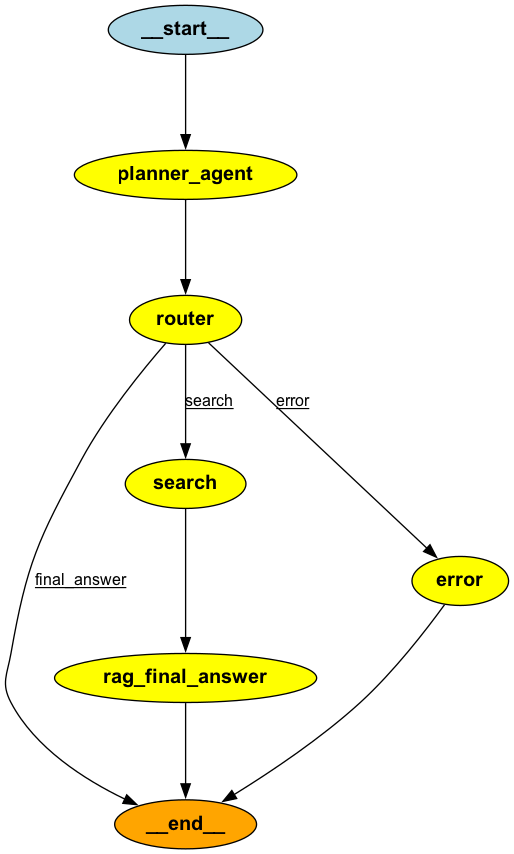

In [16]:
# to see the graph using pygraphviz
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [17]:
# sample run

runnable = graph.compile()

# add API here
out = runnable.invoke({
    "input": "what I should not do in providing immediate care?",
    "intermediate_steps": []
})

> run_planner_agent
> router
> execute_search
> final_answer


In [21]:
# FASTAPI API
# WILL ONLY RUN in py file

import nest_asyncio

nest_asyncio.apply()

from fastapi import FastAPI, HTTPException

from pydantic import BaseModel

from typing import List, Optional

import uvicorn

from fastapi.testclient import TestClient

app = FastAPI(title="Sukoon API", description="API for the Sukoon mental health support system")

class SukoonRequest(BaseModel):

    input: str

    intermediate_steps: Optional[List[dict]] = []

class SukoonResponse(BaseModel):

    answer: str

    source: str

runnable = graph.compile()

@app.post("/query", response_model=SukoonResponse)

async def process_query(request: SukoonRequest):

    try:

        out = runnable.invoke({

            "input": request.input,

            "intermediate_steps": request.intermediate_steps

        })

        result = json.loads(out["agent_out"])

        return SukoonResponse(answer=result["answer"], source=result["source"])

    except Exception as e:

        raise HTTPException(status_code=500, detail=str(e))

@app.get("/")

async def root():

    return {"message": "Welcome to the Sukoon API. Use the /query endpoint to interact with the system."}

# Create a test client

client = TestClient(app)

# Function to make a query to the API

def query_sukoon(input_text):

    response = client.post("/query", json={"input": input_text, "intermediate_steps": []})

    if response.status_code == 200:

        return response.json()

    else:

        return {"error": response.text}

# if __name__ == "__main__":
#     uvicorn.run(app, host="0.0.0.0", port=8000)

# Example usage

print(query_sukoon("what I should not do in providing immediate care?"))

> run_planner_agent
> router
> execute_search
> final_answer
{'answer': 'When providing immediate care in mental health first aid, you should avoid pressuring someone to share their story, interrupting or rushing the person while they are speaking, giving simple and unrealistic reassurances, making false promises or minimizing their struggles, touching individuals without certainty, and criticizing existing services in front of those in need.', 'source': 'search'}


In [54]:
print(out["agent_out"])

{"answer":"When providing immediate care, you should not pressure someone to tell their story, interrupt or rush their story, give simple or unrealistic reassurances, give false promises or minimize their loss, touch them if you are unsure, or criticize existing services in front of people in need.","source":"search"}


In [55]:
# printing in nice format
import pprint

text = json.dumps(out["agent_out"], indent = 2)
output_text = {
    "agent_out": {text}
}

final_output = json.loads(out["agent_out"])
print(json.dumps(final_output, indent=2))
# pprint.pprint(final_output, width=60)

{
  "answer": "When providing immediate care, you should not pressure someone to tell their story, interrupt or rush their story, give simple or unrealistic reassurances, give false promises or minimize their loss, touch them if you are unsure, or criticize existing services in front of people in need.",
  "source": "search"
}


In [56]:
# to see intermediate steps 
pprint.pprint(out, indent = 4)

{   'agent_out': '{"answer":"When providing immediate care, you should not '
                 'pressure someone to tell their story, interrupt or rush '
                 'their story, give simple or unrealistic reassurances, give '
                 'false promises or minimize their loss, touch them if you are '
                 'unsure, or criticize existing services in front of people in '
                 'need.","source":"search"}',
    'input': 'what I should not do in providing immediate care?',
    'intermediate_steps': [   {   'search': 'Do not pressure someone to tell '
                                            'their story, do not interrupt or '
                                            'rush the story, do not give '
                                            'simple, unrealistic reassurances, '
                                            'do not give false promises or '
                                            'minimize their loss, do not touch '
                     

In [57]:
# error case
out = runnable.invoke({
    "input": "hi",
    "intermediate_steps": []
})
print(out["agent_out"])

> run_planner_agent
> router
> handle_error
{"answer":"Hello! How can I assist you today?","source":"Common greeting response"}
